In [1]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

In [2]:
def rescale(image):
    return image / 255.0

In [3]:
def rotate(image):
    angle = random.randint(-20, 20)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

In [4]:
def brightness_contrast(image):
    alpha = random.uniform(0.8, 1.2)  # Contrast control
    beta = random.randint(-20, 20)    # Brightness control
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [5]:
def gaussian_blur(image):
    return cv2.GaussianBlur(image, (3, 3), 0)

In [6]:
def add_random_gaussian_noise(image):
    noise_intensity = np.random.uniform(0, 0.3)
    sigma = noise_intensity * 255
    noise = np.random.normal(0, sigma, image.shape).astype('float32')
    noisy_image = image.astype('float32') + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return noisy_image

In [7]:
def width_shift(image):
    h, w = image.shape[:2]
    tx = random.uniform(-0.2, 0.2) * w
    M = np.float32([[1, 0, tx], [0, 1, 0]])
    return cv2.warpAffine(image, M, (w, h))

In [8]:
def height_shift(image):
    h, w = image.shape[:2]
    ty = random.uniform(-0.2, 0.2) * h
    M = np.float32([[1, 0, 0], [0, 1, ty]])
    return cv2.warpAffine(image, M, (w, h))

In [9]:
def shear(image):
    h, w = image.shape[:2]
    shear = random.uniform(-0.2, 0.2)
    M = np.float32([[1, shear, 0], [0, 1, 0]])
    return cv2.warpAffine(image, M, (w, h))

In [10]:
def zoom(image):
    zoom = random.uniform(0.9, 1.1)
    return cv2.resize(image, None, fx=zoom, fy=zoom)

In [11]:
def horizontal_flip(image):
    if random.random() < 0.5:
        return cv2.flip(image, 1)
    return image

In [12]:
def augment_image(image):
    image = rescale(image)
    image = rotate(image)
    image = brightness_contrast(image)
    image = gaussian_blur(image)
    image = add_random_gaussian_noise(image)
    image = width_shift(image)
    image = height_shift(image)
    image = shear(image)
    image = zoom(image)
    image = horizontal_flip(image)
    return cv2.resize(image, target_shape)

In [13]:
classpaths = os.path.join(os.getcwd(), 'image')
classes = os.listdir(classpaths)
numofclasses = len(classes)

Path = []
Class = []

for index, name in enumerate(classes):
    class_dir = os.path.join(classpaths, name)
    for image_name in os.listdir(class_dir):
        impath = os.path.join(class_dir, image_name)
        Path.append(impath)
        Class.append(name)

df = pd.DataFrame({'Path': Path, 'Class': Class})
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Class'])
df.to_csv('data.csv', index=False)

In [14]:
df

Path     Class  Type
0      D:\Work\DS\image\antelope\00000-2074659866.png  antelope     0
1      D:\Work\DS\image\antelope\00001-2074659867.png  antelope     0
2      D:\Work\DS\image\antelope\00002-2074659868.png  antelope     0
3      D:\Work\DS\image\antelope\00003-2074659869.png  antelope     0
4      D:\Work\DS\image\antelope\00004-2074659870.png  antelope     0
...                                               ...       ...   ...
14372       D:\Work\DS\image\wolf\08419-688626930.png      wolf    63
14373       D:\Work\DS\image\wolf\08420-688626931.png      wolf    63
14374       D:\Work\DS\image\wolf\08421-688626932.png      wolf    63
14375       D:\Work\DS\image\wolf\08422-688626933.png      wolf    63
14376       D:\Work\DS\image\wolf\08423-688626934.png      wolf    63

[14377 rows x 3 columns]

In [15]:
print(f"Dataset Dimensions: {df.shape}")

Dataset Dimensions: (14377, 3)


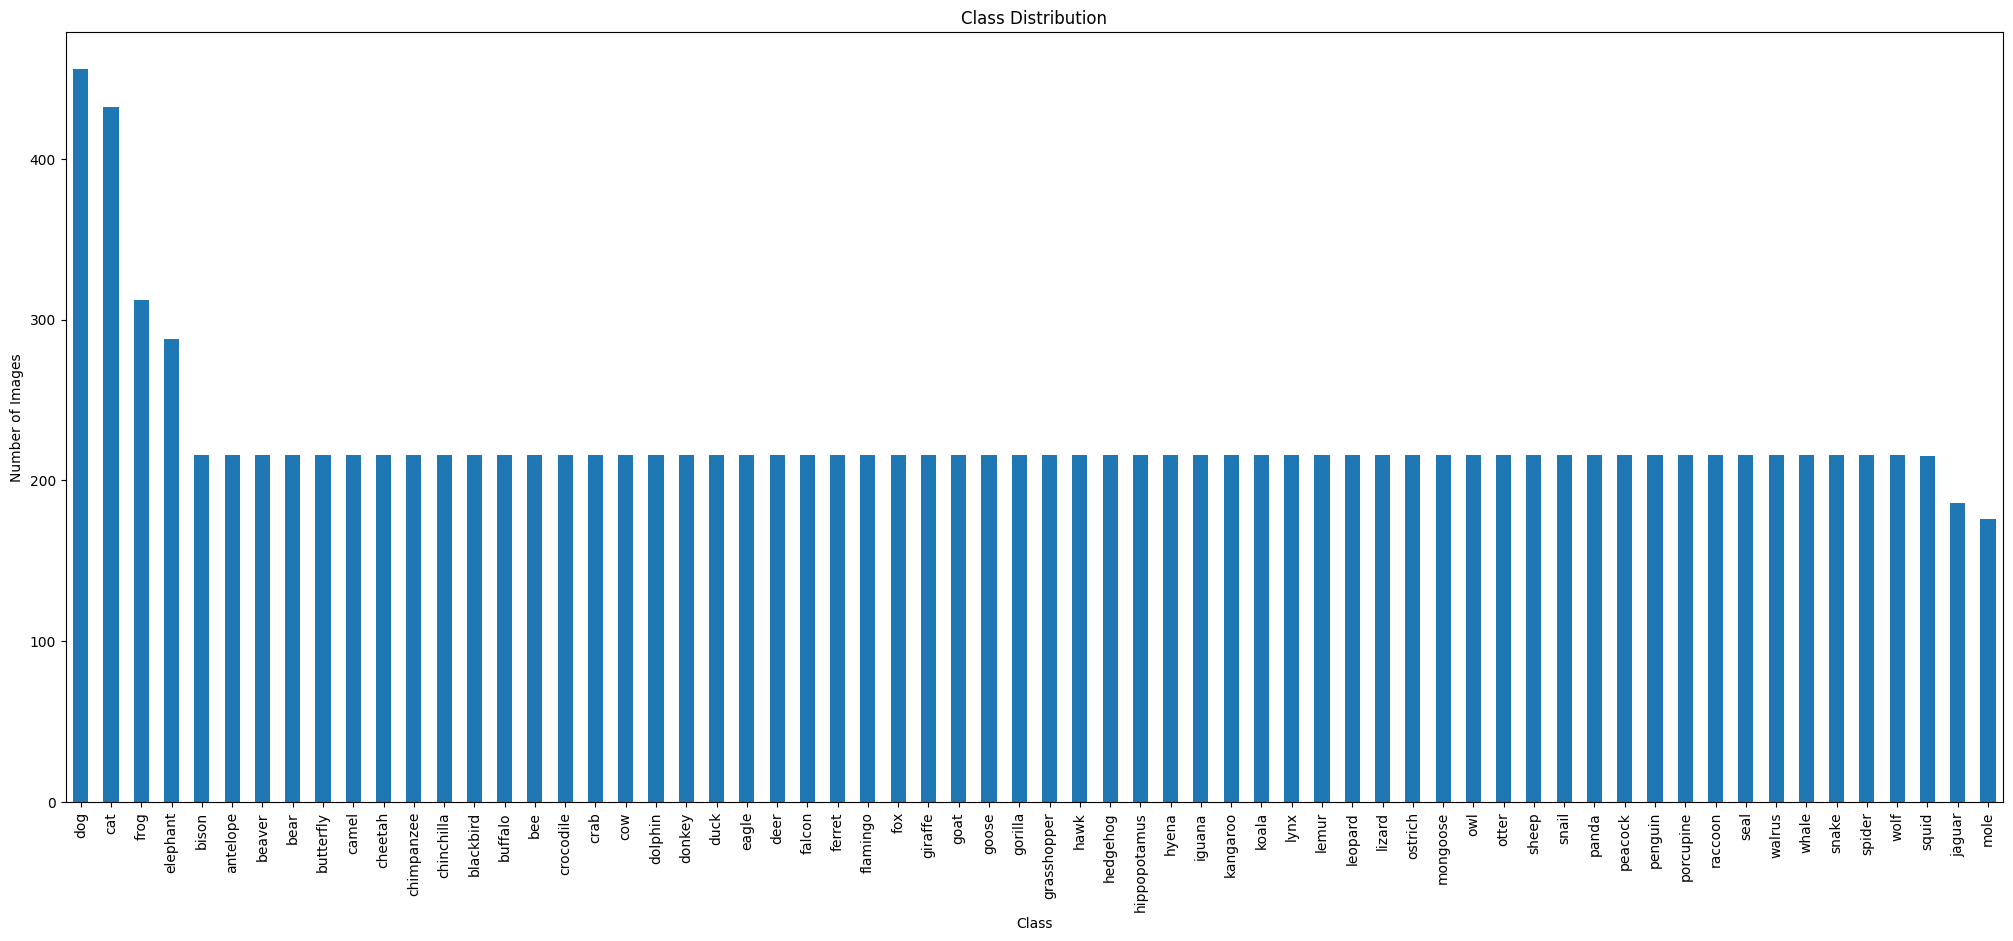

In [16]:
class_counts = df['Class'].value_counts()
plt.figure(figsize=(25, 10))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

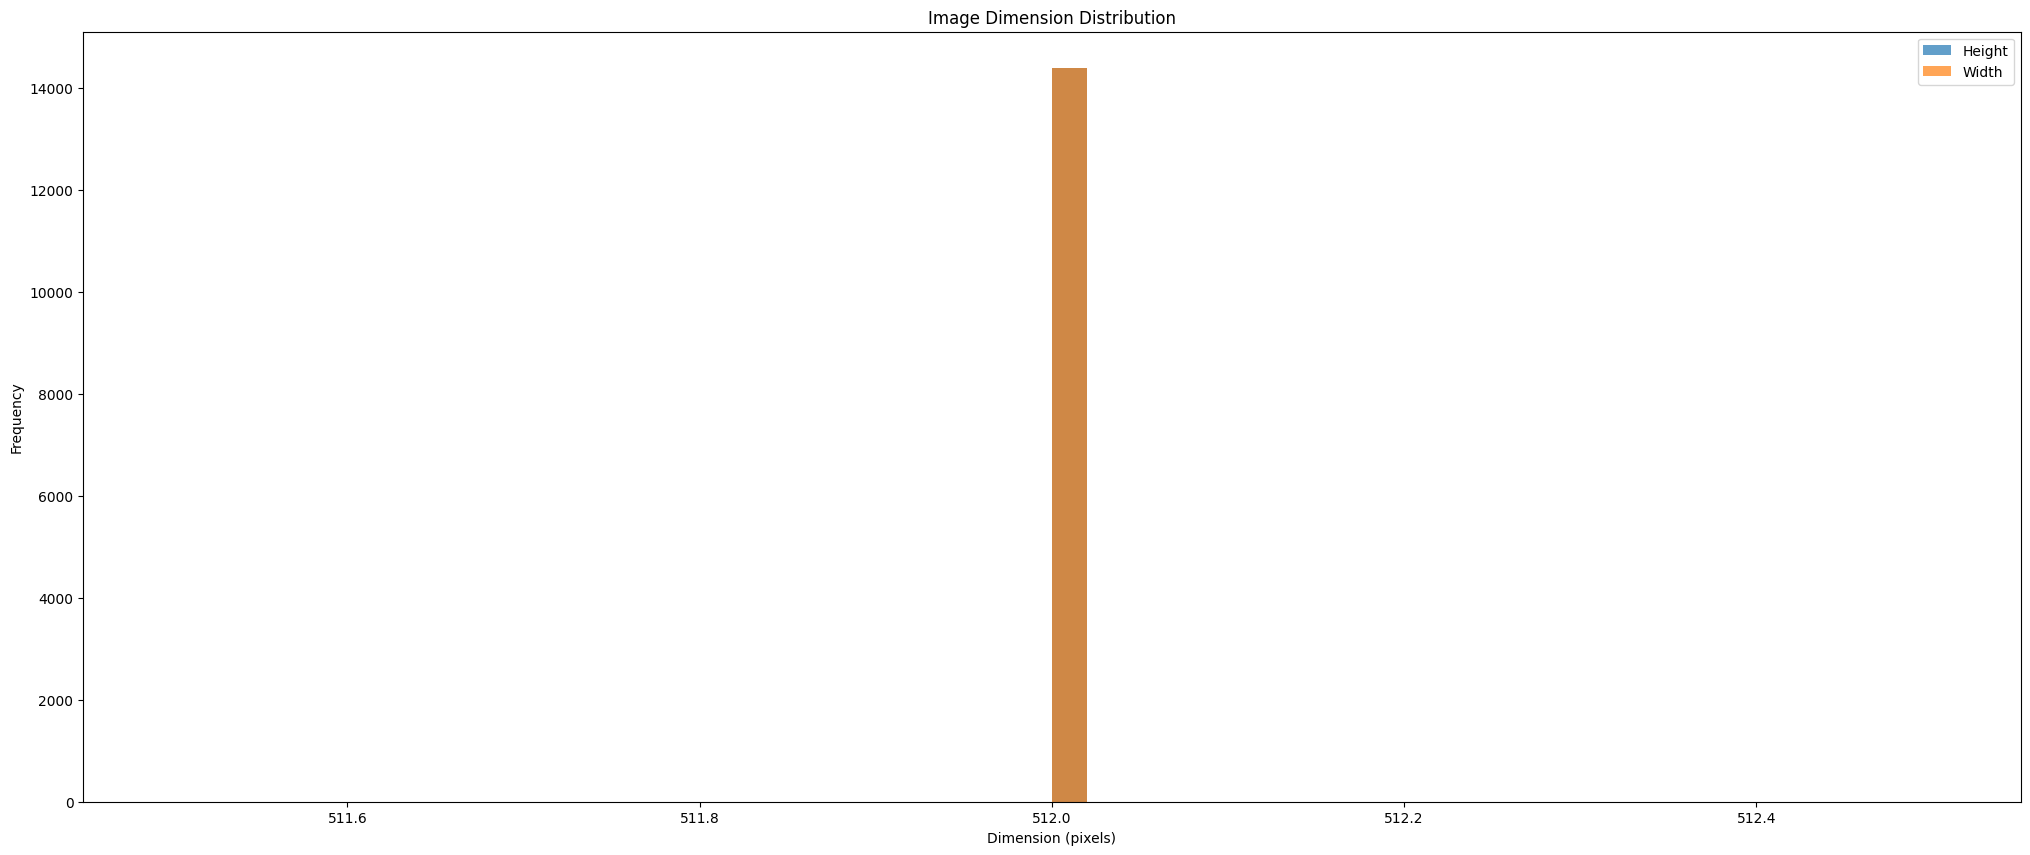

In [28]:
heights = [cv2.imread(path).shape[0] for path in df['Path']]
widths = [cv2.imread(path).shape[1] for path in df['Path']]

plt.figure(figsize=(25, 10))
plt.hist(heights, bins=50, alpha=0.7, label='Height')
plt.hist(widths, bins=50, alpha=0.7, label='Width')
plt.title('Image Dimension Distribution')
plt.xlabel('Dimension (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

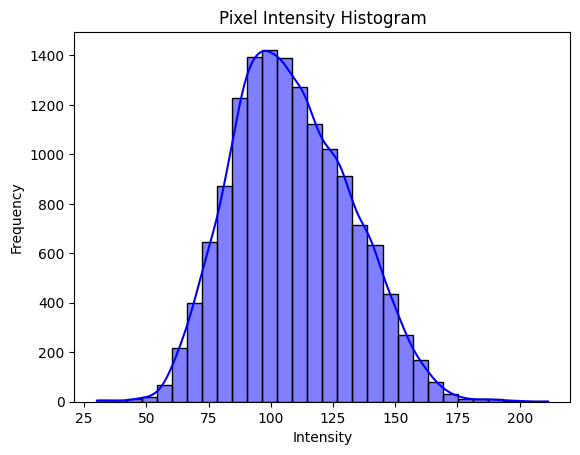

In [53]:
avg_intensities = [np.mean(cv2.imread(path)) for path in df['Path']]
sns.histplot(avg_intensities, kde=True, bins=30, color='blue')
plt.title('Pixel Intensity Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

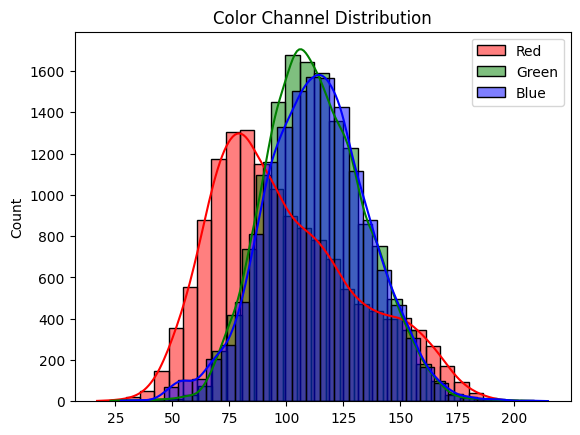

In [54]:
for channel, color in enumerate(['Red', 'Green', 'Blue']):
    values = [cv2.imread(path)[:, :, channel].mean() for path in df['Path']]
    sns.histplot(values, kde=True, bins=30, color=color.lower(), label=color)
plt.legend()
plt.title('Color Channel Distribution')
plt.show()

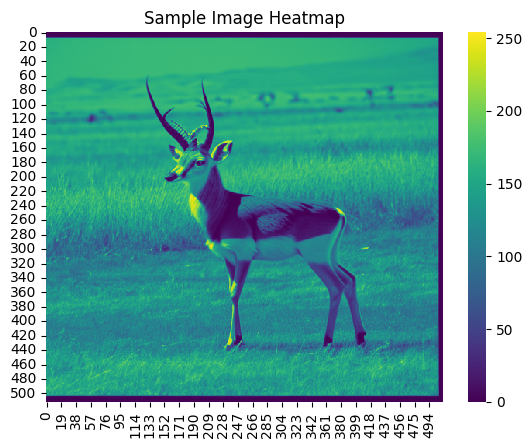

In [56]:
sample_image = cv2.imread(df['Path'].iloc[0], cv2.IMREAD_GRAYSCALE)
sns.heatmap(sample_image, cmap='viridis')
plt.title('Sample Image Heatmap')
plt.show()


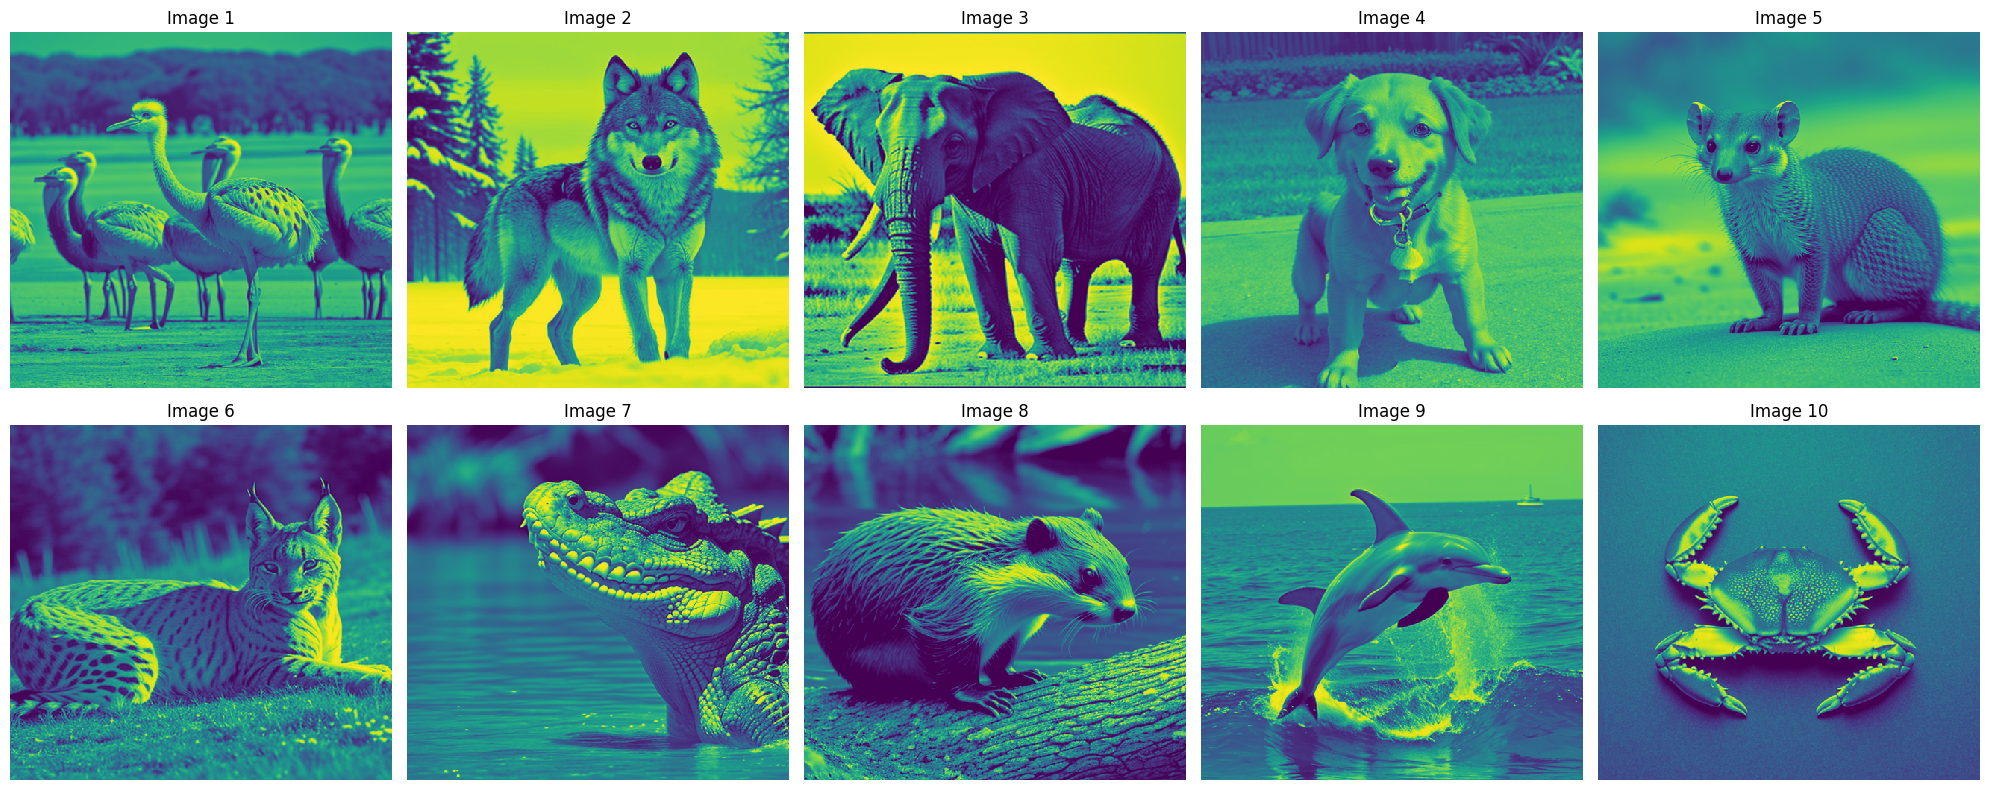

In [55]:
random_samples = df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axes.flat):
    sample_image = cv2.imread(random_samples['Path'].iloc[i], cv2.IMREAD_GRAYSCALE)
    sns.heatmap(sample_image, cmap='viridis', ax=ax, cbar=False)
    ax.set_title(f"Image {i + 1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

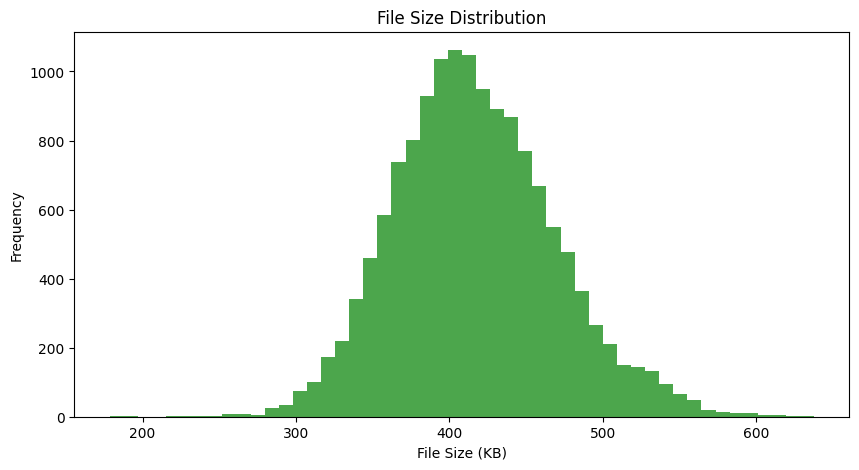

In [30]:
file_sizes = [os.path.getsize(path) / 1024 for path in df['Path']]
plt.figure(figsize=(10, 5))
plt.hist(file_sizes, bins=50, color='green', alpha=0.7)
plt.title('File Size Distribution')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.show()

<Figure size 2500x1000 with 0 Axes>

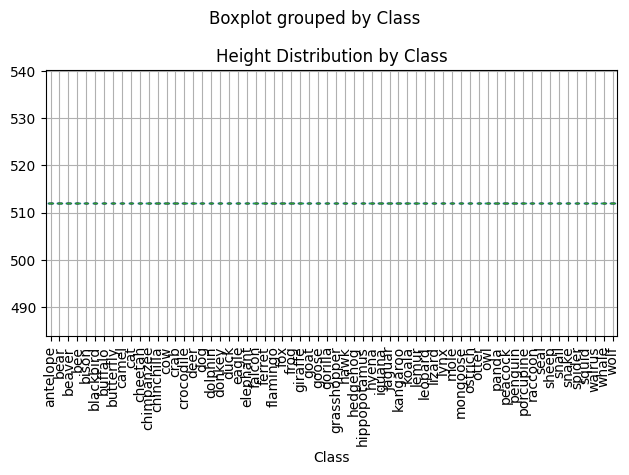

In [31]:
class_vs_height = pd.DataFrame({'Class': df['Class'], 'Height': heights})

plt.figure(figsize=(25, 10))
class_vs_height.boxplot(by='Class', column=['Height'], rot=90)
plt.title('Height Distribution by Class')
plt.tight_layout()
plt.show()

<Figure size 2500x1000 with 0 Axes>

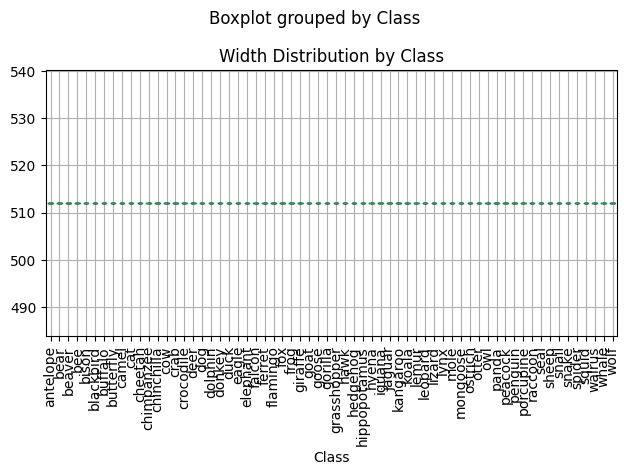

In [32]:
class_vs_width = pd.DataFrame({'Class': df['Class'], 'Width': widths})

plt.figure(figsize=(25, 10))
class_vs_width.boxplot(by='Class', column=['Width'], rot=90)
plt.title('Width Distribution by Class')
plt.tight_layout()
plt.show()

<Figure size 2500x1000 with 0 Axes>

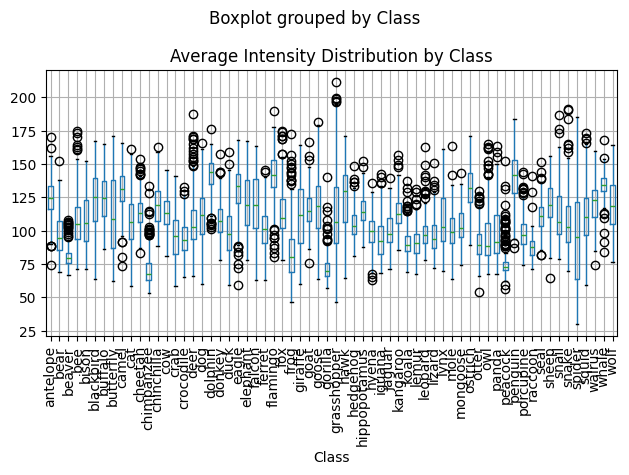

In [33]:
class_vs_intensity = pd.DataFrame({'Class': df['Class'], 'Intensity': avg_intensities})

plt.figure(figsize=(25, 10))
class_vs_intensity.boxplot(by='Class', column=['Intensity'], rot=90)
plt.title('Average Intensity Distribution by Class')
plt.tight_layout()
plt.show()

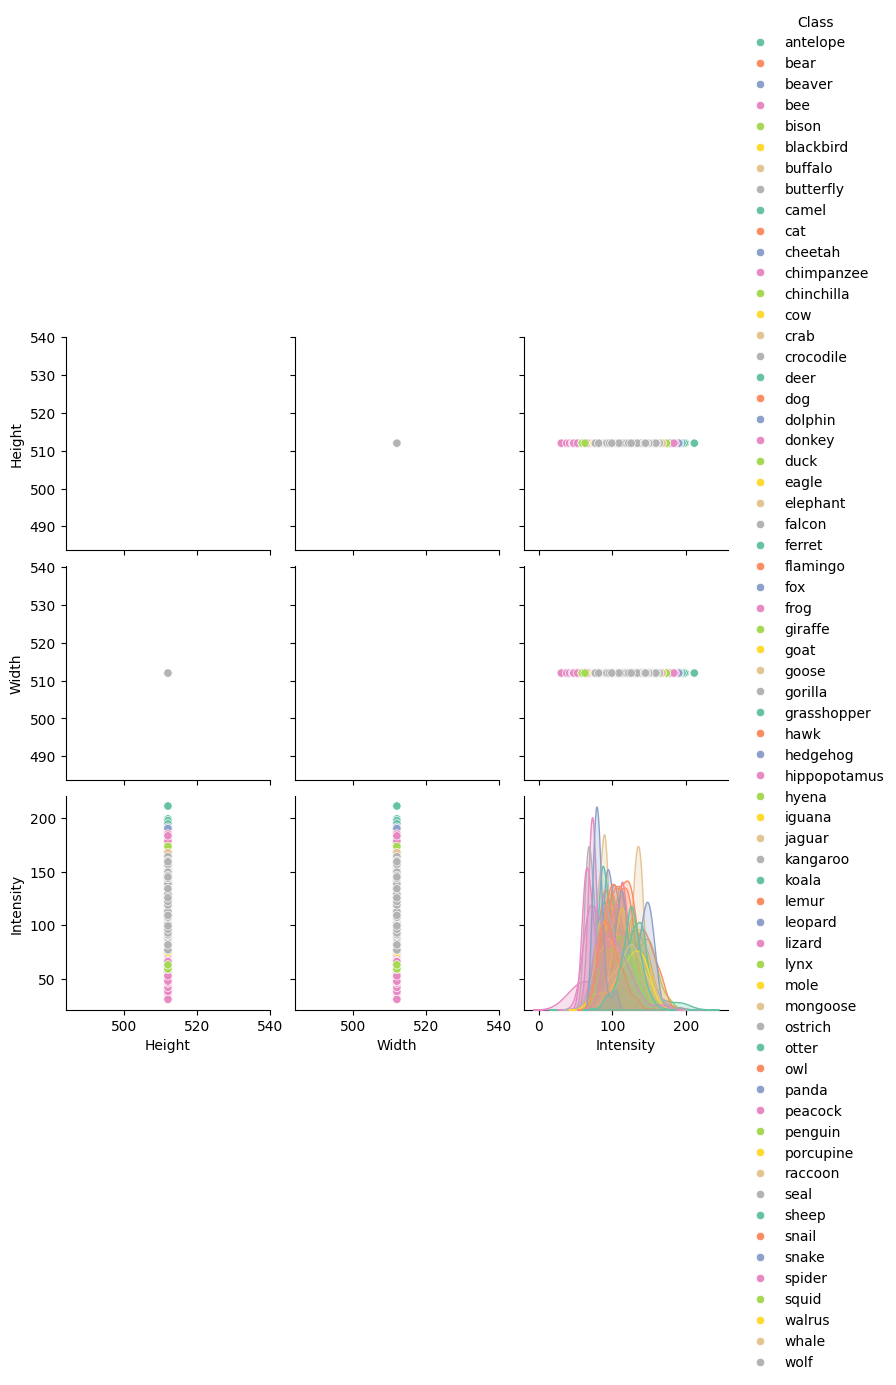

In [34]:
feature_df = pd.DataFrame({
    'Height': heights,
    'Width': widths,
    'Intensity': avg_intensities,
    'Class': df['Class']
})

sns.pairplot(feature_df, hue='Class', vars=['Height', 'Width', 'Intensity'], palette='Set2')
plt.show()

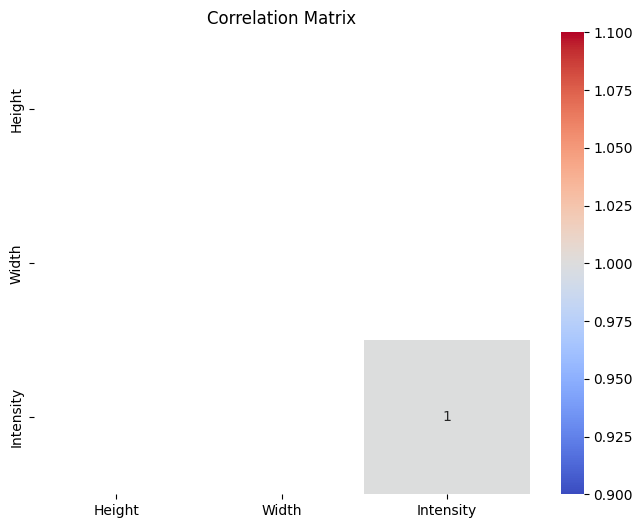

In [35]:
correlation_data = feature_df[['Height', 'Width', 'Intensity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [36]:
descriptive_stats = pd.DataFrame({
    'Height': heights,
    'Width': widths,
    'Intensity': avg_intensities
}).describe()

print(descriptive_stats)


        Height    Width     Intensity
count  14377.0  14377.0  14377.000000
mean     512.0    512.0    108.365211
std        0.0      0.0     23.563105
min      512.0    512.0     30.144850
25%      512.0    512.0     91.104824
50%      512.0    512.0    106.423073
75%      512.0    512.0    125.031802
max      512.0    512.0    211.309153


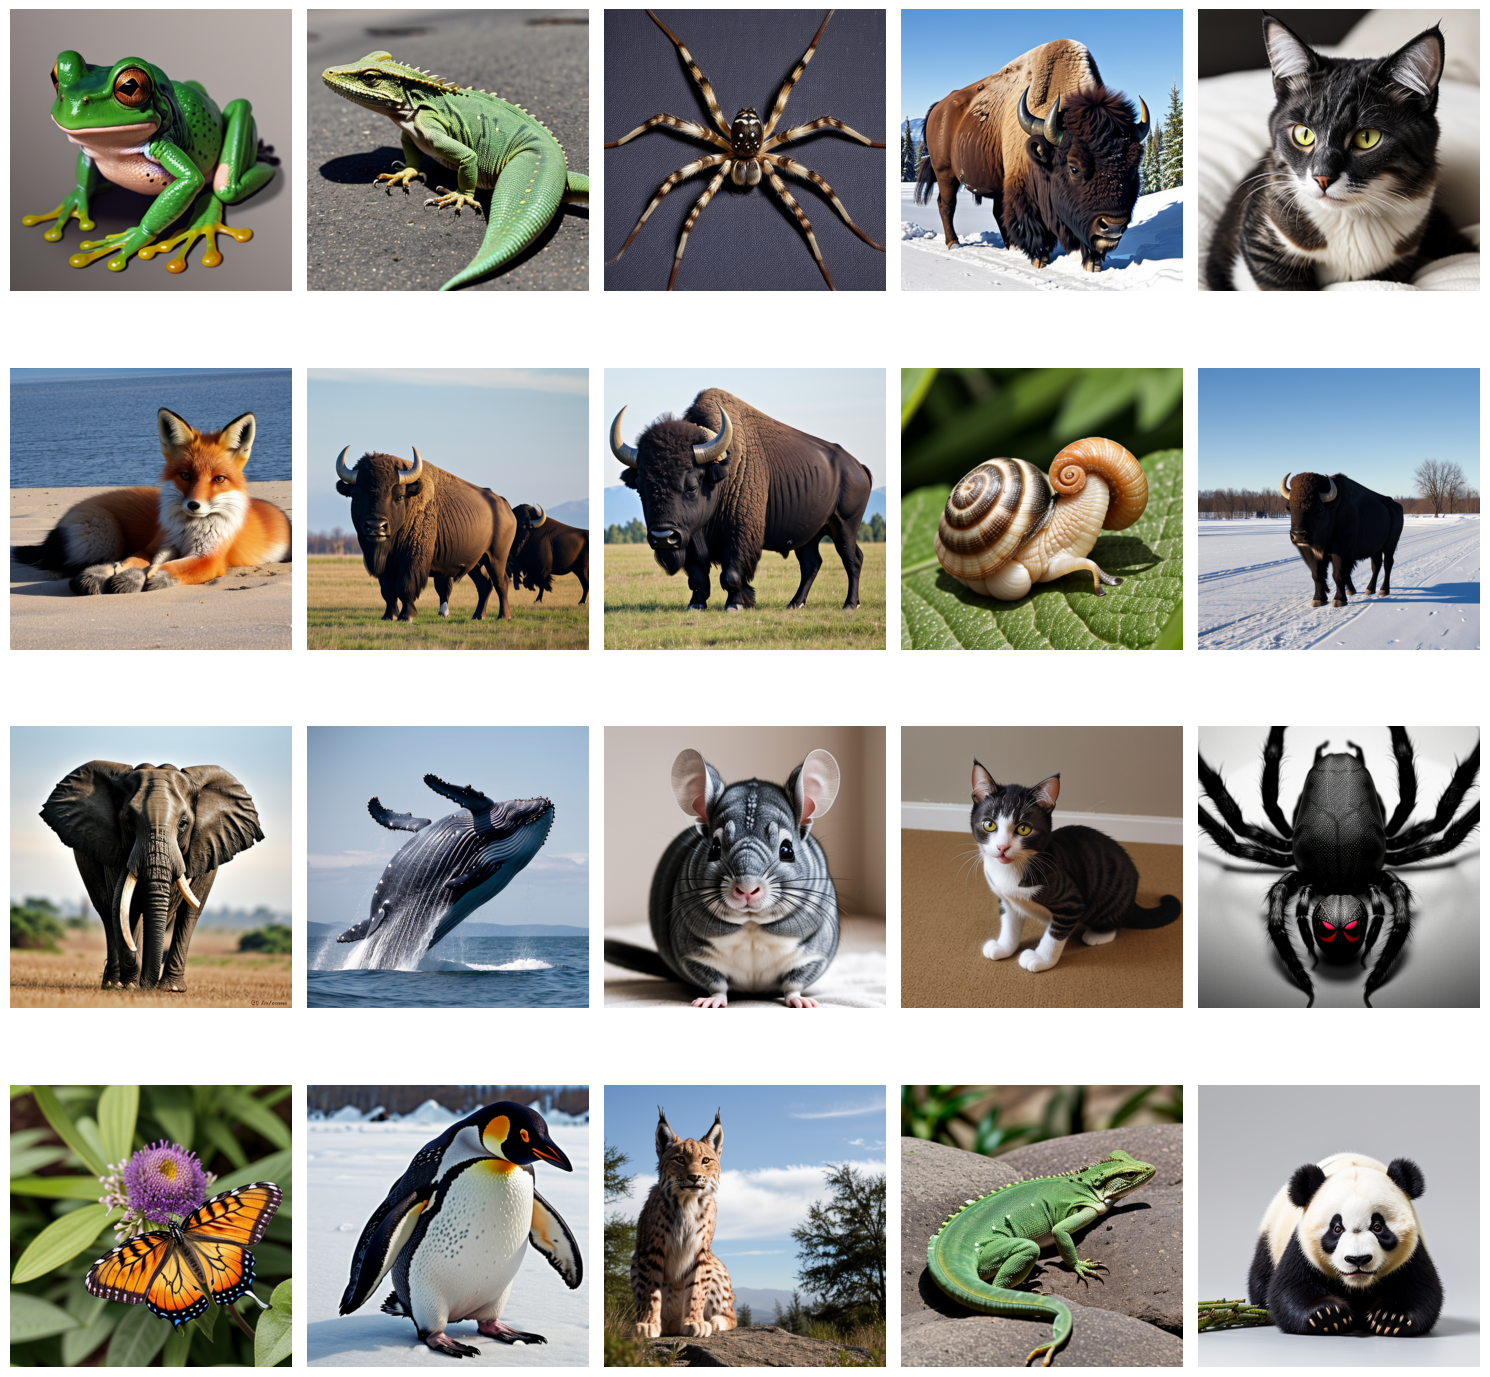

In [37]:
sample_images = random.sample(df['Path'].tolist(), 20)

plt.figure(figsize=(15, 15))

for i, image_path in enumerate(sample_images):
    image = cv2.imread(image_path)
    if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 5, i+1)
        plt.imshow(image_rgb)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
base_dir = os.path.join(os.getcwd(), 'image2')
for root, dirs, files in os.walk(base_dir):
    print(f'{root} contains: {dirs}')

D:\Work\DS\image2 contains: ['antelope', 'bear', 'beaver', 'bee', 'bison', 'blackbird', 'buffalo', 'butterfly', 'camel', 'cat', 'cheetah', 'chimpanzee', 'chinchilla', 'cow', 'crab', 'crocodile', 'deer', 'dog', 'dolphin', 'donkey', 'duck', 'eagle', 'elephant', 'falcon', 'ferret', 'flamingo', 'fox', 'frog', 'giraffe', 'goat', 'goose', 'gorilla', 'grasshopper', 'hawk', 'hedgehog', 'hippopotamus', 'hyena', 'iguana', 'jaguar', 'kangaroo', 'koala', 'lemur', 'leopard', 'lizard', 'lynx', 'mole', 'mongoose', 'ostrich', 'otter', 'owl', 'panda', 'peacock', 'penguin', 'porcupine', 'raccoon', 'seal', 'sheep', 'snail', 'snake', 'spider', 'squid', 'train', 'val', 'walrus', 'whale', 'wolf']
D:\Work\DS\image2\antelope contains: []
D:\Work\DS\image2\bear contains: []
D:\Work\DS\image2\beaver contains: []
D:\Work\DS\image2\bee contains: []
D:\Work\DS\image2\bison contains: []
D:\Work\DS\image2\blackbird contains: []
D:\Work\DS\image2\buffalo contains: []
D:\Work\DS\image2\butterfly contains: []
D:\Work\D

In [16]:
base_dir = 'D:/Work/DS/image2'
split_ratio = 0.8

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if class_name in ['train', 'val'] or not os.path.isdir(class_dir):
        continue
    
    images = [img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]
    random.shuffle(images)
    split_index = int(len(images) * split_ratio)

    train_class_dir = os.path.join(base_dir, 'train', class_name)
    val_class_dir = os.path.join(base_dir, 'val', class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in images[:split_index]:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    
    for img in images[split_index:]:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_class_dir, img))

print("Dataset split into train and validation sets.")

Dataset split into train and validation sets.


In [17]:
def normalize_image(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet means
    std = np.array([0.229, 0.224, 0.225])   # ImageNet stds
    img = (img - mean) / std
    return img

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=normalize_image
)

val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=normalize_image)

train_generator = train_datagen.flow_from_directory(
    'D:/Work/DS/image2/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'D:/Work/DS/image2/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 11452 images belonging to 64 classes.
Found 2925 images belonging to 64 classes.


In [19]:
numofclasses

64

In [35]:
train_classes, train_counts = np.unique(train_generator.classes, return_counts=True)
val_classes, val_counts = np.unique(val_generator.classes, return_counts=True)

train_class_names = list(train_generator.class_indices.keys())
val_class_names = list(val_generator.class_indices.keys())

train_class_counts = {train_class_names[i]: count for i, count in zip(train_classes, train_counts)}
val_class_counts = {val_class_names[i]: count for i, count in zip(val_classes, val_counts)}

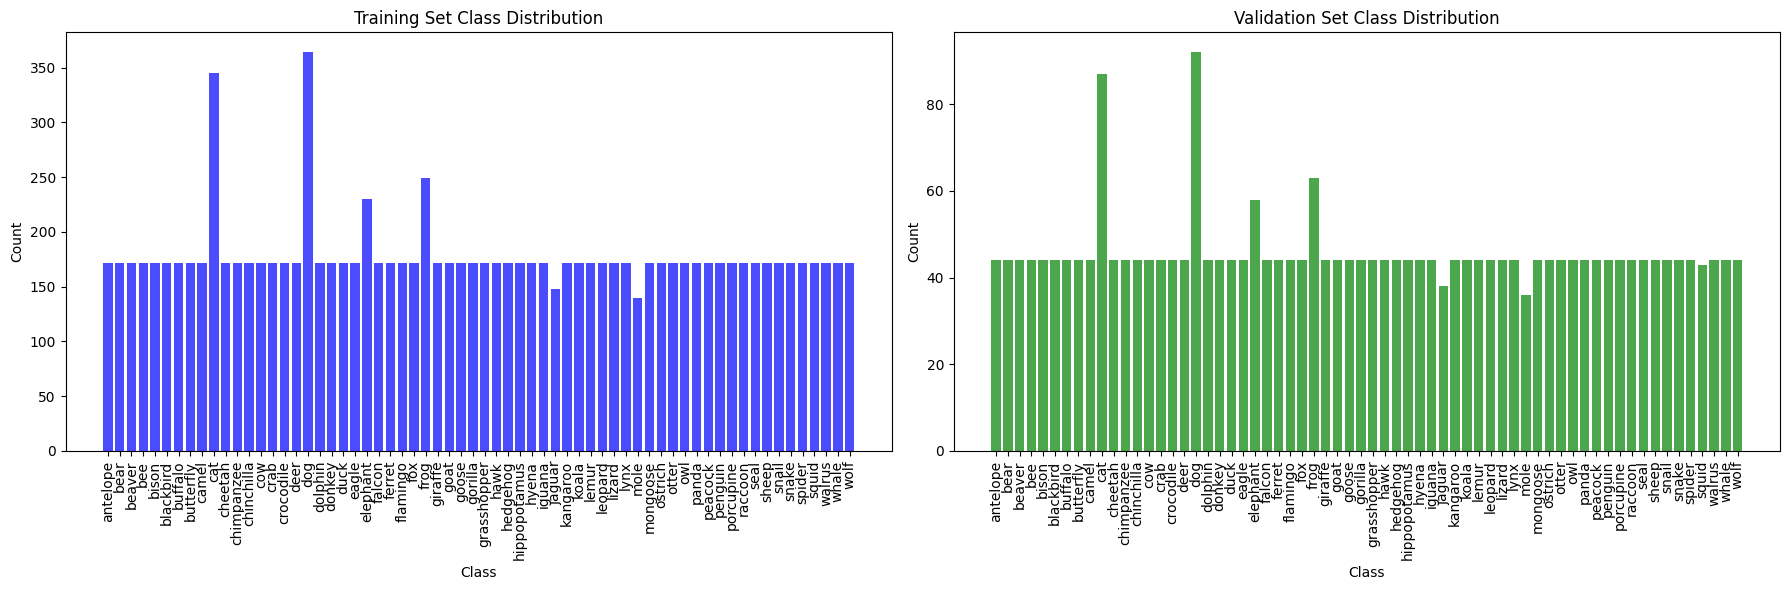

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].bar(train_class_names, train_counts, color='blue', alpha=0.7)
ax[0].set_title("Training Set Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(val_class_names, val_counts, color='green', alpha=0.7)
ax[1].set_title("Validation Set Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [18]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(numofclasses, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [22]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(numofclasses, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,793,536 (247.17 MB)

 Trainable params: 64,642,112 (246.59 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [20]:
model = load_model('res152animalclass1.h5')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

C:\Users\Zee Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1038s 6s/step - accuracy: 0.8331 - loss: 1.1066 - val_accuracy: 0.9029 - val_loss: 0.8076
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1023s 6s/step - accuracy: 0.8703 - loss: 0.9086 - val_accuracy: 0.9084 - val_loss: 0.7414
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1019s 6s/step - accuracy: 0.8730 - loss: 0.8376 - val_accuracy: 0.9101 - val_loss: 0.6974
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1009s 6s/step - accuracy: 0.8635 - loss: 0.8217 - val_accuracy: 0.9094 - val_loss: 0.6849
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1020s 6s/step - accuracy: 0.8779 - loss: 0.7743 - val_accuracy: 0.9125 - val_loss: 0.6519
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1020s 6s/step - accuracy: 0.8913 - loss: 0.7375 - val_accuracy: 0.9166 - val_loss: 0.6208
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1025s 6s/step - accuracy: 0.8851 - loss: 0.7150 - val_accuracy: 0.9115 - val_loss: 0.6290
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1025s 6s/step - accuracy: 0.8920 - loss: 0.6824 - 

In [22]:
model.save('res152animalclass2.h5')

In [23]:
test_loss, test_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.9267 - loss: 0.4751
Test Accuracy: 0.9234
Test Loss: 0.4852


In [32]:
y_pred = []
y_true = []

for batch_images, batch_labels in val_generator:
    y_pred_batch = model.predict(batch_images)
    y_pred.extend(y_pred_batch)
    y_true.extend(batch_labels)

    if len(y_true) >= val_generator.samples:
        break

y_pred = np.array(y_pred)
y_true = np.array(y_true)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [40]:
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

if y_pred_classes.ndim > 1:
    y_pred_classes = np.argmax(y_pred_classes, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[41  0  0 ...  0  0  0]
 [ 0 39  0 ...  0  0  0]
 [ 0  0 42 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  0  0]
 [ 0  0  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 42]]


In [42]:
report = classification_report(y_true, y_pred_classes, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    antelope       0.98      0.93      0.95        44
        bear       0.97      0.89      0.93        44
      beaver       0.89      0.95      0.92        44
         bee       0.97      0.89      0.93        44
       bison       0.79      0.84      0.81        44
   blackbird       0.89      0.93      0.91        44
     buffalo       0.78      0.80      0.79        44
   butterfly       0.98      1.00      0.99        44
       camel       0.91      0.89      0.90        44
         cat       0.93      0.95      0.94        87
     cheetah       0.98      0.95      0.97        44
  chimpanzee       0.91      0.98      0.95        44
  chinchilla       0.96      1.00      0.98        44
         cow       0.81      0.89      0.85        44
        crab       0.91      0.98      0.95        44
   crocodile       0.98      0.98      0.98        44
        deer       0.83      0.89      0.86        44
   

In [46]:
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

if y_pred.ndim == 2 and y_pred.shape[1] == num_classes:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred

In [48]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true == i, y_pred[:, i])


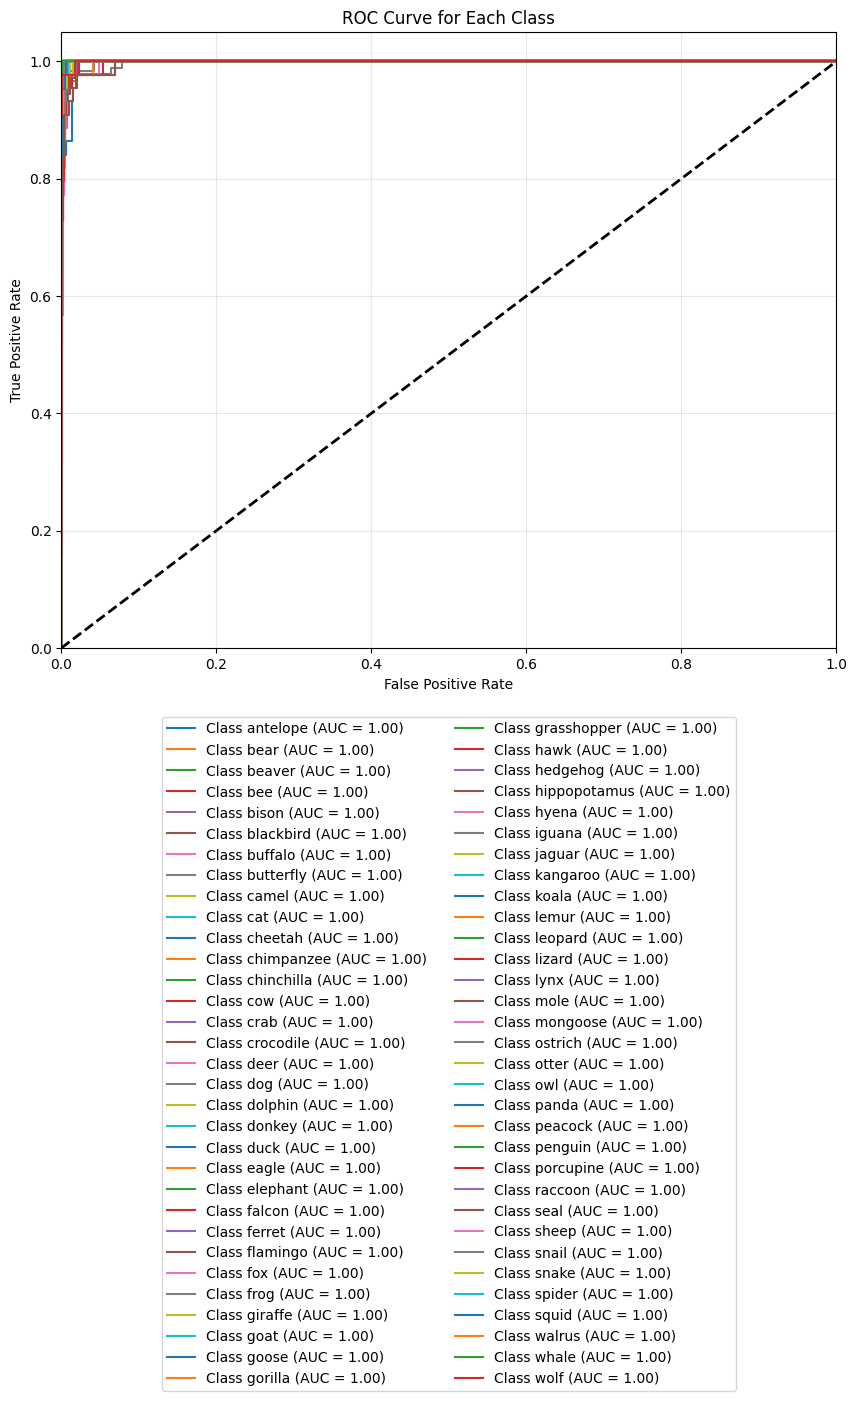

In [51]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {list(val_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.grid(alpha=0.3)
plt.show()